# Adversarial Patch Defence


## Imports & Globals

In [69]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F
os.chdir('/home/jovyan/DL_Project02')
!pwd

/home/jovyan/DL_Project02


## Load Dataset and Calssification model

In [70]:

DATA_ROOT = "./data_gtsrb"
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_set = datasets.GTSRB(
    DATA_ROOT, 
    split="train", 
    download=True, 
    transform=tfms
)

test_set  = datasets.GTSRB(
    DATA_ROOT, 
    split="test",  
    download=True, 
    transform=tfms
)

indices = random.sample(range(len(train_set)), 600)
small_train_set = Subset(train_set, indices)

indices = random.sample(range(len(test_set)), 600)
small_test_set = Subset(test_set, indices)

test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)


cuda


In [4]:

CKPT_PATH = "./ResNet_Models/resnet101_gtsrb_best.pt"
NUM_CLASSES = 43
weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(DEVICE).eval();

## Patch Segmentation Dataset

In [41]:
# class PatchSegmentationDataset(Dataset):
#     def __init__(self, base_dataset, patch, patch_size):
#         self.base_dataset = base_dataset
#         self.patch = patch.detach().cpu()   # ensure CPU tensor
#         self.patch_size = patch_size

#     def __len__(self):
#         return len(self.base_dataset)

#     def __getitem__(self, idx):
#         img, _ = self.base_dataset[idx]
#         img = img.clone()                   # safety

#         _, H, W = img.shape
                
#         mask = torch.zeros((1, H, W), dtype=torch.float32)

#         # random patch position
#         x = random.randint(0, W - self.patch_size)
#         y = random.randint(0, H - self.patch_size)

#         # apply patch
#         img[:, y:y+self.patch_size, x:x+self.patch_size] = self.patch

#         # ground-truth mask
#         mask[:, y:y+self.patch_size, x:x+self.patch_size] = 1.0

#         return img, mask

class PatchSegmentationDataset(Dataset):
    def __init__(
        self,
        base_dataset,
        patch,
        base_patch_size=40,
        scale_range=(0.5, 1.5)   # min max scale factors
    ):
        self.base_dataset = base_dataset
        self.patch = patch.detach().cpu()   # safe
        self.base_patch_size = base_patch_size
        self.scale_range = scale_range

    def __len__(self):
        return len(self.base_dataset)

    def resize_patch(self, scale):
        new_size = int(self.base_patch_size * scale)
        new_size = max(8, new_size)  # safety

        patch = self.patch.unsqueeze(0)  # (1,C,H,W)
        patch = F.interpolate(
            patch,
            size=(new_size, new_size),
            mode="bilinear",
            align_corners=False
        )
        return patch.squeeze(0), new_size

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        img = img.clone()

        _, H, W = img.shape

        # ---- random scale ----
        scale = random.uniform(*self.scale_range)
        patch_resized, patch_size = self.resize_patch(scale)

        mask = torch.zeros((1, H, W), dtype=torch.float32)

        # ---- random position ----
        x = random.randint(0, W - patch_size)
        y = random.randint(0, H - patch_size)

        # ---- apply patch ----
        img[:, y:y+patch_size, x:x+patch_size] = patch_resized
        mask[:, y:y+patch_size, x:x+patch_size] = 1.0

        return img, mask

patch = torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")

seg_dataset = PatchSegmentationDataset(
    small_train_set, 
    patch, 
    base_patch_size=40
    )
seg_loader = DataLoader(seg_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

seg_test_dataset = PatchSegmentationDataset(
    small_test_set, 
    patch, 
    base_patch_size=40
)
seg_test_loader = DataLoader(seg_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


## Visualise train dataset

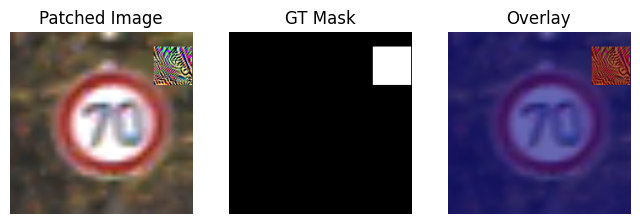

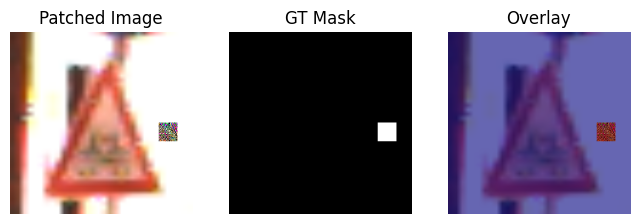

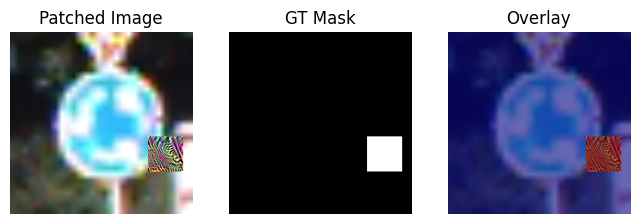

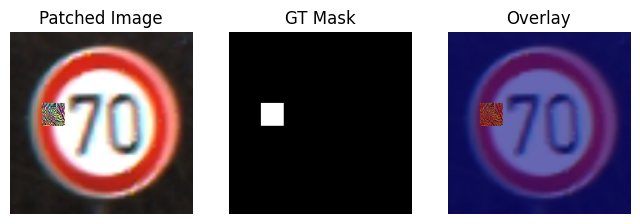

In [43]:

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean


# get one batch
images, masks = next(iter(seg_loader))
images = images[:4]
masks = masks[:4]

for i in range(4):
    img = denormalize(images[i], imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    mask = masks[i][0]

    plt.figure(figsize=(8,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img)
    plt.imshow(mask, cmap="jet", alpha=0.6)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


## Define and Train the Patch detector
A U-model is used to detect the patches using as a mask as ground truth  

In [35]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3, 64)
        self.d2 = DoubleConv(64, 128)
        self.b = DoubleConv(128, 256)
        self.u1 = DoubleConv(256 + 128, 128)
        self.u2 = DoubleConv(128 + 64, 64)
        self.out = nn.Conv2d(64, 1, 1)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        c1 = self.d1(x)
        c2 = self.d2(self.pool(c1))
        b = self.b(self.pool(c2))
        u1 = self.u1(torch.cat([torch.nn.functional.interpolate(b, scale_factor=2), c2], dim=1))
        u2 = self.u2(torch.cat([torch.nn.functional.interpolate(u1, scale_factor=2), c1], dim=1))
        return torch.sigmoid(self.out(u2))


In [47]:
EPOCHS = 20

train_seg_model = UNet().cuda()
opt = torch.optim.Adam(train_seg_model.parameters(), 1e-4)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    total_loss = 0.0

    for images, masks in seg_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        preds = train_seg_model(images)
        loss = loss_fn(preds, masks)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: avg loss = {total_loss / len(seg_loader):.4f}")

torch.save(train_seg_model.state_dict(), "./Segmentation_Models/seg_Umodel_varyPatch.pth")

Epoch 1: avg loss = 0.2451
Epoch 2: avg loss = 0.0111
Epoch 3: avg loss = 0.0033
Epoch 4: avg loss = 0.0022
Epoch 5: avg loss = 0.0018
Epoch 6: avg loss = 0.0013
Epoch 7: avg loss = 0.0010
Epoch 8: avg loss = 0.0012
Epoch 9: avg loss = 0.0006
Epoch 10: avg loss = 0.0005
Epoch 11: avg loss = 0.0005
Epoch 12: avg loss = 0.0004
Epoch 13: avg loss = 0.0003
Epoch 14: avg loss = 0.0003
Epoch 15: avg loss = 0.0003
Epoch 16: avg loss = 0.0002
Epoch 17: avg loss = 0.0002
Epoch 18: avg loss = 0.0001
Epoch 19: avg loss = 0.0001
Epoch 20: avg loss = 0.0002


## Visualise the segmentation results

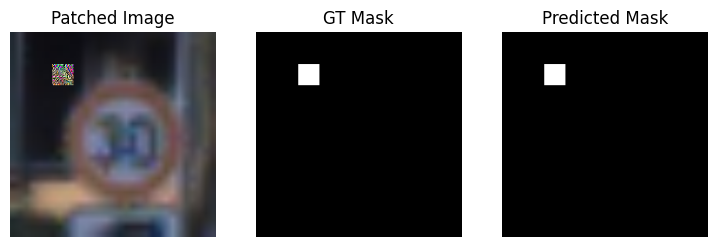

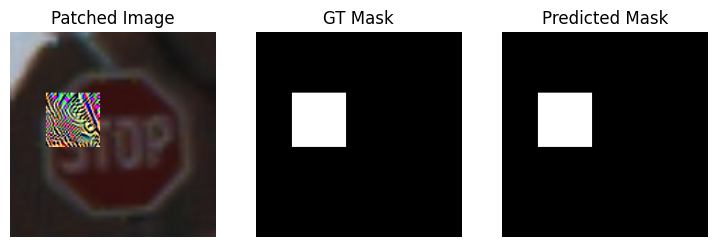

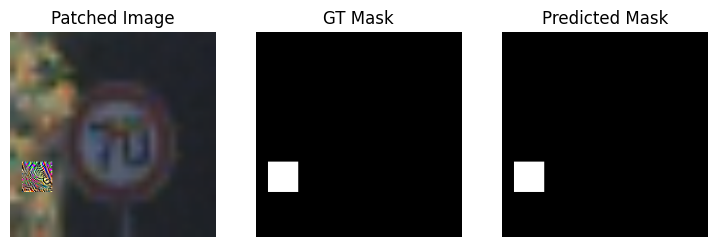

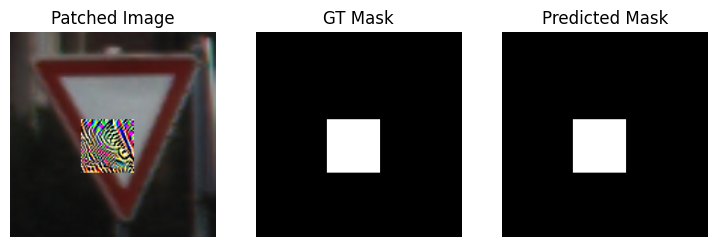

In [71]:

seg_model = UNet()   # or your exact model class
seg_model.load_state_dict(
    torch.load("./Segmentation_Models/seg_Umodel_varyPatch.pth", map_location=DEVICE)
)
seg_model = seg_model.to(DEVICE)
seg_model.eval();

with torch.no_grad():
    images, masks = next(iter(seg_test_loader))
    images = images[:4].to(DEVICE)
    masks = masks[:4]

    preds = seg_model(images).cpu()

for i in range(4):
    img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    img = img.permute(1,2,0).clamp(0,1)

    gt_mask = masks[i][0]
    pred_mask = (preds[i][0] > 0.5).float()

    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Patched Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("GT Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [24]:
def remove_patch(images, masks):
    """
    images: [B,3,H,W]
    masks:  [B,1,H,W]
    """
    cleaned = images.clone()

    masks = masks.expand(-1, 3, -1, -1)

    # image-wise mean color
    mean = images.mean(dim=[2,3], keepdim=True)

    cleaned[masks > 0.5] = mean.expand_as(cleaned)[masks > 0.5]

    return cleaned


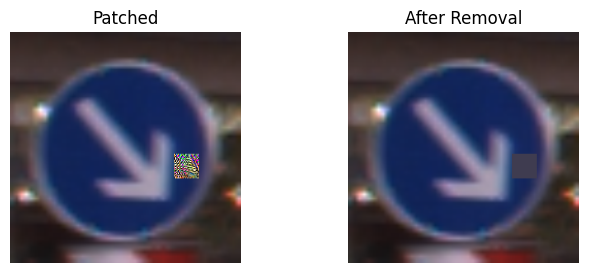

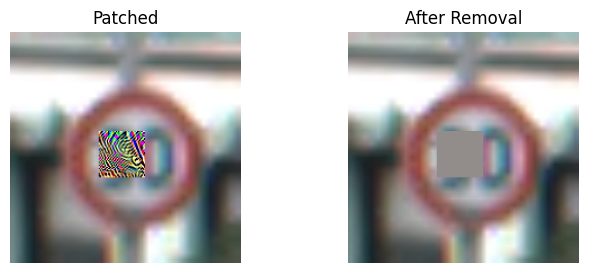

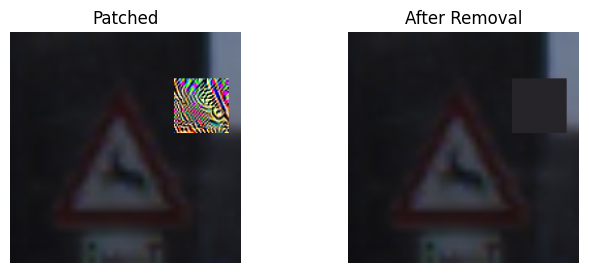

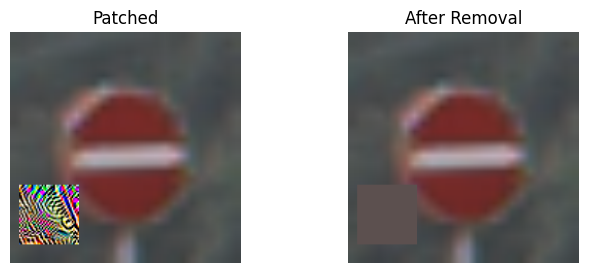

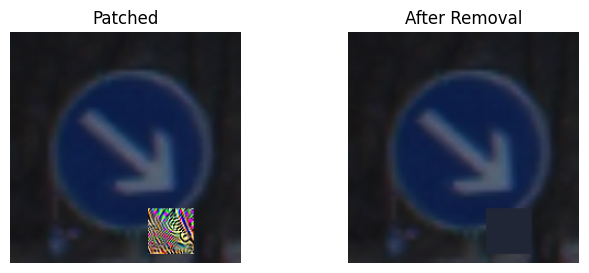

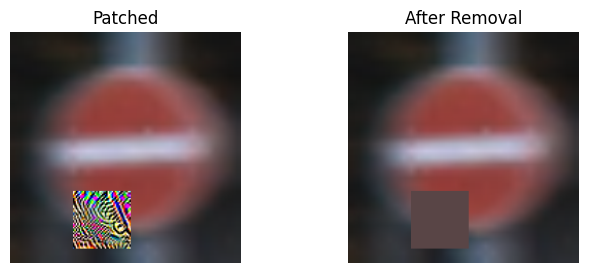

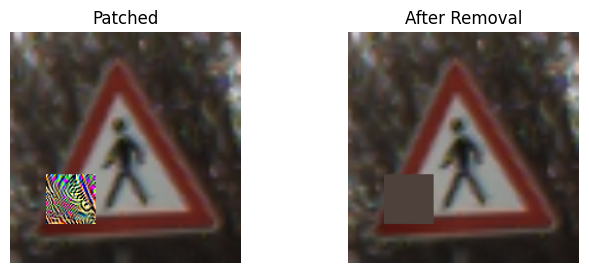

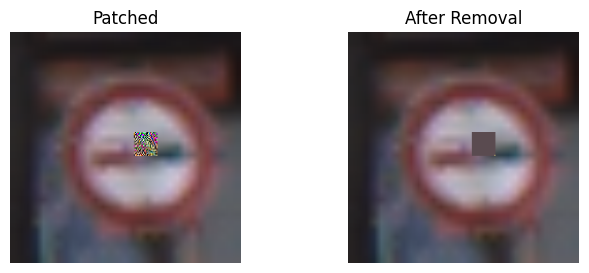

In [73]:
with torch.no_grad():
    images, _ = next(iter(seg_test_loader))
    images = images.to(DEVICE)

    #patched = apply_patch(images, patch)
    pred_mask = seg_model(images)
    cleaned = remove_patch(images, pred_mask)

for i in range(8):
    p_img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    c_img = denormalize(cleaned[i].cpu(), imagenet_mean, imagenet_std)

    p_img = p_img.permute(1,2,0).clamp(0,1)
    c_img = c_img.permute(1,2,0).clamp(0,1)

    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(p_img)
    plt.title("Patched")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(c_img)
    plt.title("After Removal")
    plt.axis("off")

    plt.show()


## Measure Accuracy

In [74]:
def resize_patch(patch, new_size):
    if isinstance(new_size, int):
        new_size = (new_size, new_size)

    patch = patch.unsqueeze(0)  # [1,3,H,W]
    patch = F.interpolate(
        patch,
        size=new_size,
        mode="bilinear",
        align_corners=False
    )
    return patch.squeeze(0)     # [3,new_H,new_W]

def apply_patch(
    images,
    base_patch=patch,
    min_size=20,
    max_size=60
):
    B, C, H, W = images.shape
    patched = images.clone()

    for i in range(B):
        patch_size = random.randint(min_size, max_size)
        patch = resize_patch(base_patch, patch_size)

        x = random.randint(0, W - patch_size)
        y = random.randint(0, H - patch_size)

        patched[i, :, y:y+patch_size, x:x+patch_size] = patch

    return patched.clamp(-2.5, 2.5)


def build_defended_dataset(
    base_loader,
    apply_patch,
    seg_model,
    device
):
    seg_model.eval()

    defended_images = []
    defended_labels = []

    with torch.no_grad():
        for images, labels in base_loader:
            images = images.to(device)
            labels = labels.to(device)

            # apply attack once
            patched = apply_patch(images)

            # detect patch
            masks = seg_model(patched)

            # remove patch
            defended = remove_patch(patched, masks)

            defended_images.append(defended.cpu())
            defended_labels.append(labels.cpu())

    defended_images = torch.cat(defended_images)
    defended_labels = torch.cat(defended_labels)

    return TensorDataset(defended_images, defended_labels)


defended_dataset = build_defended_dataset(
    test_loader,
    apply_patch,
    seg_model,
    DEVICE
)

defended_loader = DataLoader(
    defended_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)
    


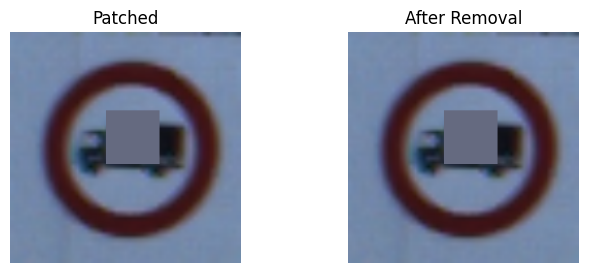

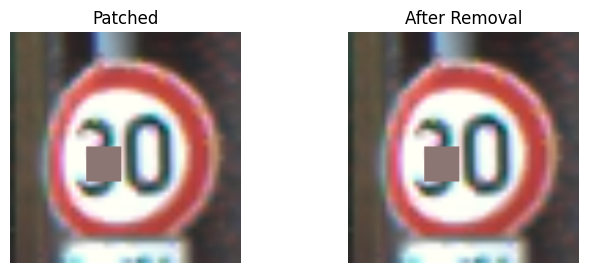

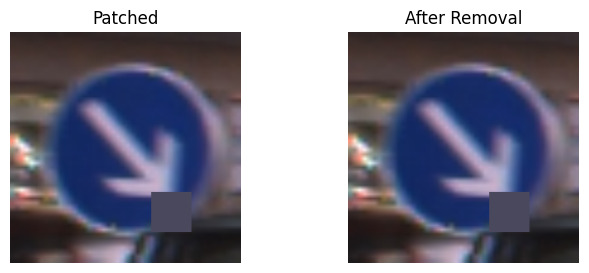

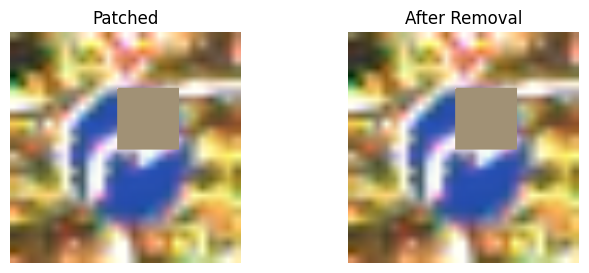

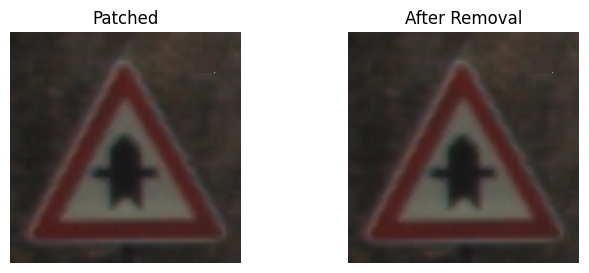

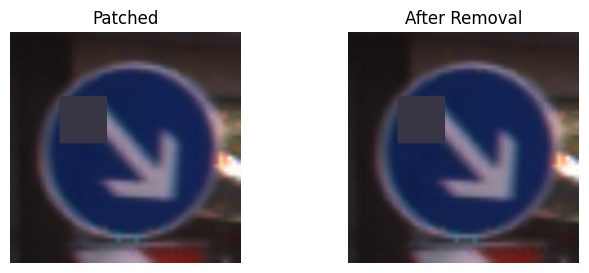

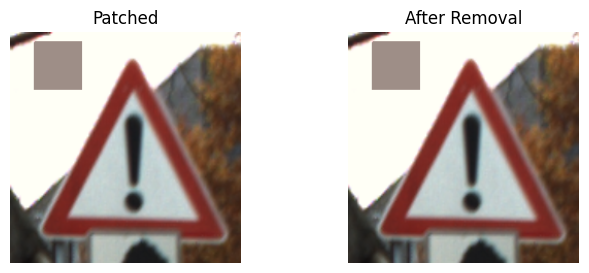

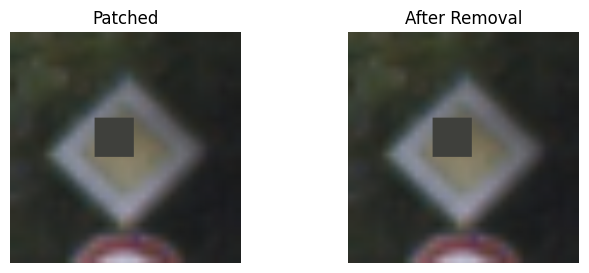

In [75]:
with torch.no_grad():
    images, _ = next(iter(defended_loader))
    images = images.to(DEVICE)

    #patched = apply_patch(images, patch)
    pred_mask = seg_model(images)
    cleaned = remove_patch(images, pred_mask)

for i in range(8):
    p_img = denormalize(images[i].cpu(), imagenet_mean, imagenet_std)
    c_img = denormalize(cleaned[i].cpu(), imagenet_mean, imagenet_std)

    p_img = p_img.permute(1,2,0).clamp(0,1)
    c_img = c_img.permute(1,2,0).clamp(0,1)

    plt.figure(figsize=(8,3))

    plt.subplot(1,2,1)
    plt.imshow(p_img)
    plt.title("Patched")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(c_img)
    plt.title("After Removal")
    plt.axis("off")

    plt.show()


In [76]:
def evaluate_clean(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


defended_acc = evaluate_clean(model, defended_loader)
print(f"Defended Accuracy: {defended_acc*100:.2f}%")


Defended Accuracy: 97.36%
